## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = 'Gel_Studies/11_09_18_gel_experiment' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 20
gels = ['0_4', '0_6', '0_8', '1_0', '1_2']
nonnum = ['Percent Agarose', 'Well', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
featofvar = 'Percent Agarose'

counter = 0
for gel in gels:
    for num in range(1, vids+1):
        try:
            filename = 'features_Gels_{}_XY{}.csv'.format(gel, '%02d' % num)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Percent Agarose'] = pd.Series(fstats.shape[0]*[gel], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            if num < 11:
                fstats['Well'] = pd.Series(fstats.shape[0]*[1], index=fstats.index)
            else:
                fstats['Well'] = pd.Series(fstats.shape[0]*[2], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        except:
            print('skip filename {}'.format(filename))

features_Gels_0_4_XY01.csv size: (3607, 67)
features_Gels_0_4_XY02.csv size: (3890, 67)
features_Gels_0_4_XY03.csv size: (4543, 67)
features_Gels_0_4_XY04.csv size: (4153, 67)
features_Gels_0_4_XY05.csv size: (4455, 67)
features_Gels_0_4_XY06.csv size: (4436, 67)
features_Gels_0_4_XY07.csv size: (4190, 67)
features_Gels_0_4_XY08.csv size: (4719, 67)
features_Gels_0_4_XY09.csv size: (5617, 67)
features_Gels_0_4_XY10.csv size: (7329, 67)
features_Gels_0_4_XY11.csv size: (3595, 67)
features_Gels_0_4_XY12.csv size: (3530, 67)
features_Gels_0_4_XY13.csv size: (4386, 67)
features_Gels_0_4_XY14.csv size: (5257, 67)
features_Gels_0_4_XY15.csv size: (6141, 67)
features_Gels_0_4_XY16.csv size: (4488, 67)
features_Gels_0_4_XY17.csv size: (5058, 67)
features_Gels_0_4_XY18.csv size: (3697, 67)
features_Gels_0_4_XY19.csv size: (3615, 67)
features_Gels_0_4_XY20.csv size: (3327, 67)
features_Gels_0_6_XY01.csv size: (4973, 67)
features_Gels_0_6_XY02.csv size: (0, 67)
features_Gels_0_6_XY03.csv size: (4

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [ ]:
for typ in fstats_tot['Particle Size'].unique():
    fstats_type = fstats_tot[fstats_tot['Particle Size']==typ].reset_index(drop=True)
    print(fstats_type.shape)

In [ ]:
#with equal sample sizes for each particle type
import random
counter = 0
for typ in fstats_tot['Particle Size'].unique():
    fstats_type = fstats_tot[fstats_tot['Particle Size']==typ].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 55000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

In [3]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_num = fstats_tot.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [3]:
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=16)

Cumulative explained variance:
0 component: 0.17871066378741954
1 component: 0.29243087532185974
2 component: 0.37950273085847325
3 component: 0.451678500935929
4 component: 0.5069304902693856
5 component: 0.5523168414909048
6 component: 0.5915643716727608
7 component: 0.6236911360204789
8 component: 0.6547209460714423
9 component: 0.6838514074684837
10 component: 0.7107445756679183
11 component: 0.7354833365294088
12 component: 0.7595210265202214
13 component: 0.7798264117682037
14 component: 0.7986066300688742
15 component: 0.8157725697450362


In [12]:
pcadataset.components.to_csv('components.csv')
aws.upload_s3('components.csv', '{}/components.csv'.format(remote_folder, filename), bucket_name=bucket)

In [5]:
fstats_num.columns

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'frames', 'Quality',
       'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames',
       'Mean Quality', 'Std Quality', 'Mean SN_Ratio', 'Std SN_Ratio',
       'Mean Deff1', 'Std Deff1', 'Mean Deff2', 'Std Deff2'],
      dtype='object

In [ ]:
kmostat = pca.kmo(pcadataset.scaled)

The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [19]:
import numpy as np
ncomp = 16
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Percent Agarose']=='0_4'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Percent Agarose']=='0_6'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Percent Agarose']=='0_8'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final['Percent Agarose']=='1_0'].values[:, -ncomp:], axis=0)
dicti[4] = np.nanmean(pcadataset.final[pcadataset.final['Percent Agarose']=='1_2'].values[:, -ncomp:], axis=0)

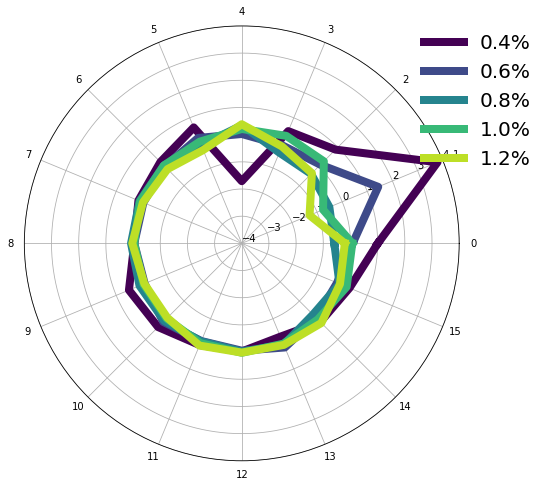

In [21]:
pca.plot_pca(dicti, savefig=True, labels=['0.4%', '0.6%', '0.8%', '1.0%', '1.2%'], rticks=np.linspace(-4, 4, 9))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [22]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Mean fractal_dim,Mean Quality,asymmetry3,straightness,Std asymmetry3,boundedness,Mean D_fit,trappedness,straightness,Std kurtosis,Std MSD_ratio,Std Deff2,D_fit,Std kurtosis,Std alpha,Std SN_Ratio
1,Mean efficiency,Mean Deff2,asymmetry2,efficiency,Std asymmetry2,trappedness,D_fit,boundedness,frames,Std fractal_dim,Std fractal_dim,Std MSD_ratio,Std kurtosis,Std MSD_ratio,Std D_fit,Std AR
2,Mean straightness,Mean kurtosis,asymmetry1,fractal_dim,Std elongation,Mean boundedness,Std D_fit,frames,efficiency,Std frames,Std kurtosis,Mean MSD_ratio,kurtosis,Mean kurtosis,Mean D_fit,Mean AR
3,Mean asymmetry1,Mean_Intensity,elongation,Mean asymmetry2,Std asymmetry1,Mean trappedness,Mean alpha,Mean MSD_ratio,asymmetry1,Mean kurtosis,Mean MSD_ratio,Std trappedness,Mean kurtosis,Mean alpha,Mean alpha,Mean_Intensity
4,Mean asymmetry2,Std asymmetry3,Mean SN_Ratio,Mean asymmetry1,Mean Quality,Mean frames,alpha,Std MSD_ratio,asymmetry2,Mean frames,Mean kurtosis,Std boundedness,alpha,Mean MSD_ratio,Std Deff2,Deff2


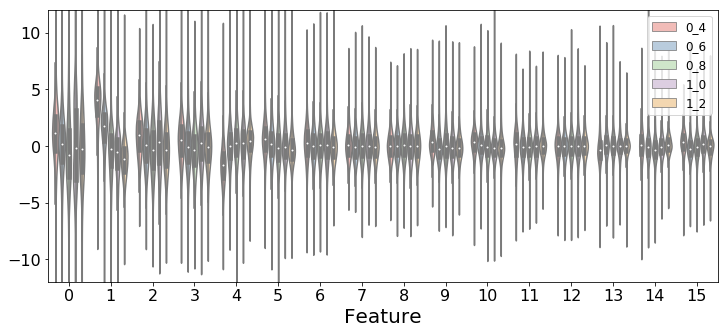

In [23]:
labels=gels
feats = pca.feature_violin(pcadataset.final, label='Percent Agarose', lvals=labels, fsubset=ncomp, yrange=[-12, 12])

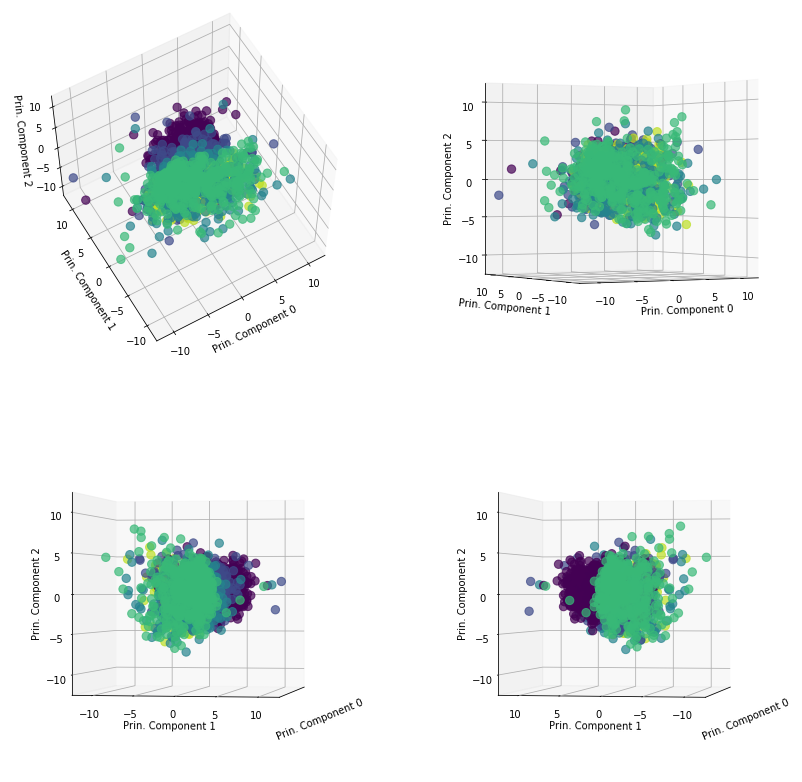

In [24]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Percent Agarose', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

In [ ]:
ncomp = 14
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Percent Agarose', labels, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Particle Size'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
fstats_num

## Neural Network

In [4]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [26]:
featofvar = 'Percent Agarose'
test = pcadataset.final.values[:, -ncomp:]
y = pcadataset.final[featofvar].values

for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.74256895
Validation score: 0.717449
Iteration 2, loss = 0.67789637
Validation score: 0.735325
Iteration 3, loss = 0.65180860
Validation score: 0.743807
Iteration 4, loss = 0.63298567
Validation score: 0.749506
Iteration 5, loss = 0.61725501
Validation score: 0.754449
Iteration 6, loss = 0.60414704
Validation score: 0.762307
Iteration 7, loss = 0.59197003
Validation score: 0.765664
Iteration 8, loss = 0.58193385
Validation score: 0.777555
Iteration 9, loss = 0.57202314
Validation score: 0.775682
Iteration 10, loss = 0.56331104
Validation score: 0.780600
Iteration 11, loss = 0.55567439
Validation score: 0.788718
Iteration 12, loss = 0.54933289
Validation score: 0.782993
Iteration 13, loss = 0.54348869
Validation score: 0.792230
Iteration 14, loss = 0.53847072
Validation score: 0.796055
Iteration 15, loss = 0.53255853
Validation score: 0.774927
Iteration 16, loss = 0.52817471
Validation score: 0.797356
Iteration 17, loss = 0.52448391
Validation score: 0.799334
Iterat

In [27]:
print('Training Results')
y_true1, y_pred1 = y_train, clf.predict(X_train)
print(classification_report(y_true1, y_pred1, digits=4))

print('Test Results')
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=4))

Training Results
             precision    recall  f1-score   support

        0_4     0.9679    0.9772    0.9726     54304
        0_6     0.8772    0.8374    0.8568     50712
        0_8     0.7914    0.7651    0.7780     55450
        1_0     0.8768    0.8376    0.8568     77425
        1_2     0.9169    0.9613    0.9386    146425

avg / total     0.8927    0.8940    0.8929    384316

Test Results

             precision    recall  f1-score   support

        0_4     0.9616    0.9717    0.9666     35729
        0_6     0.8561    0.8157    0.8354     34056
        0_8     0.7588    0.7281    0.7431     37130
        1_0     0.8507    0.8131    0.8315     51422
        1_2     0.9058    0.9521    0.9284     97875

avg / total     0.8746    0.8764    0.8751    256212



In [8]:
featofvar = 'Percent Agarose'
ncomp=16
test = pcadataset.final[pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])].values[:, -ncomp:]
y = pcadataset.final[pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])][featofvar].values

for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.31233186
Validation score: 0.886590
Iteration 2, loss = 0.27103451
Validation score: 0.891548
Iteration 3, loss = 0.25478594
Validation score: 0.894046
Iteration 4, loss = 0.24206720
Validation score: 0.903104
Iteration 5, loss = 0.23242290
Validation score: 0.906227
Iteration 6, loss = 0.22355687
Validation score: 0.910755
Iteration 7, loss = 0.21507572
Validation score: 0.914933
Iteration 8, loss = 0.20739008
Validation score: 0.912864
Iteration 9, loss = 0.20132861
Validation score: 0.923170
Iteration 10, loss = 0.19581292
Validation score: 0.925317
Iteration 11, loss = 0.18808726
Validation score: 0.921726
Iteration 12, loss = 0.18402851
Validation score: 0.928401
Iteration 13, loss = 0.17831273
Validation score: 0.932657
Iteration 14, loss = 0.17461411
Validation score: 0.930900
Iteration 15, loss = 0.17063041
Validation score: 0.935585
Iteration 16, loss = 0.16662220
Validation score: 0.934413
Iteration 17, loss = 0.16350878
Validation score: 0.935936
Iterat

## Alternate binning

In [5]:
bins = list(range(0, 2048+1, 256))
pcadataset.final['binx'] = pd.cut(pcadataset.final.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
pcadataset.final['biny'] = pd.cut(pcadataset.final.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
pcadataset.final['bins'] = 8*pcadataset.final['binx'] + pcadataset.final['biny']
pcadataset.final = pcadataset.final[np.isfinite(pcadataset.final.bins)]
pcadataset.final.bins = pcadataset.final.bins.astype(int)

cols = pcadataset.final.columns.tolist()
cols = cols[-3:] + cols[:-3]
pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
featofvar = 'Percent Agarose'
ncomp = 16

X_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
X_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
y_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))][featofvar].values
y_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.73870013
Validation score: 0.735534
Iteration 2, loss = 0.65743055
Validation score: 0.753290
Iteration 3, loss = 0.61773394
Validation score: 0.769046
Iteration 4, loss = 0.58471962
Validation score: 0.783863
Iteration 5, loss = 0.55632368
Validation score: 0.787177
Iteration 6, loss = 0.53039954
Validation score: 0.794773
Iteration 7, loss = 0.50825809
Validation score: 0.813936
Iteration 8, loss = 0.48894769
Validation score: 0.809184
Iteration 9, loss = 0.47268689
Validation score: 0.824627
Iteration 10, loss = 0.45795019
Validation score: 0.823095
Iteration 11, loss = 0.44426422
Validation score: 0.840570
Iteration 12, loss = 0.43281241
Validation score: 0.838226
Iteration 13, loss = 0.42617932
Validation score: 0.828285
Iteration 14, loss = 0.41625605
Validation score: 0.834818
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 15, loss = 0.30853185
Validation score: 0.894401
Iterat

In [7]:
featofvar = 'Percent Agarose'
ncomp = 16

X_train = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (pcadataset.final.bins.isin(checkerboard(8)))].values[:, -ncomp:]
X_test = pcadataset.final[((pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & ~pcadataset.final.bins.isin(checkerboard(8)))].values[:, -ncomp:]
y_train = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (pcadataset.final.bins.isin(checkerboard(8)))][featofvar].values
y_test = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (~pcadataset.final.bins.isin(checkerboard(8)))][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.31193449
Validation score: 0.885254
Iteration 2, loss = 0.26239132
Validation score: 0.891984
Iteration 3, loss = 0.24151905
Validation score: 0.901005
Iteration 4, loss = 0.22317702
Validation score: 0.917270
Iteration 5, loss = 0.20573033
Validation score: 0.921991
Iteration 6, loss = 0.19091969
Validation score: 0.890769
Iteration 7, loss = 0.17954945
Validation score: 0.812386
Iteration 8, loss = 0.17200756
Validation score: 0.940453
Iteration 9, loss = 0.15409832
Validation score: 0.940547
Iteration 10, loss = 0.14436036
Validation score: 0.949474
Iteration 11, loss = 0.13766511
Validation score: 0.955410
Iteration 12, loss = 0.12883380
Validation score: 0.945127
Iteration 13, loss = 0.12178588
Validation score: 0.951063
Iteration 14, loss = 0.11450939
Validation score: 0.963496
Iteration 15, loss = 0.11030980
Validation score: 0.956766
Iteration 16, loss = 0.10624861
Validation score: 0.955223
Iteration 17, loss = 0.09931150
Validation score: 0.959103
Valida

In [9]:
featofvar = 'Percent Agarose'
ncomp = 16
training = [1, 3, 5, 7] + checkerboard(8)

X_train = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (pcadataset.final.bins.isin(training))].values[:, -ncomp:]
X_test = pcadataset.final[((pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & ~pcadataset.final.bins.isin(training))].values[:, -ncomp:]
y_train = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (pcadataset.final.bins.isin(training))][featofvar].values
y_test = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (~pcadataset.final.bins.isin(training))][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.15)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.31634690
Validation score: 0.881783
Iteration 2, loss = 0.27000396
Validation score: 0.892890
Iteration 3, loss = 0.24818085
Validation score: 0.905105
Iteration 4, loss = 0.23124778
Validation score: 0.911254
Iteration 5, loss = 0.21573180
Validation score: 0.918677
Iteration 6, loss = 0.20169591
Validation score: 0.916600
Iteration 7, loss = 0.18926589
Validation score: 0.932637
Iteration 8, loss = 0.17676115
Validation score: 0.927430
Iteration 9, loss = 0.16600405
Validation score: 0.935546
Iteration 10, loss = 0.15740101
Validation score: 0.940088
Iteration 11, loss = 0.14919290
Validation score: 0.945462
Iteration 12, loss = 0.14160850
Validation score: 0.950087
Iteration 13, loss = 0.13273972
Validation score: 0.954076
Iteration 14, loss = 0.12860328
Validation score: 0.945379
Iteration 15, loss = 0.12397802
Validation score: 0.954851
Iteration 16, loss = 0.11889006
Validation score: 0.952525
Iteration 17, loss = 0.11419957
Validation score: 0.959588
Iterat

In [14]:
[64 - x for x in checkerboard(8)][::3]

[64, 58, 51, 46, 39, 33, 28, 21, 16, 10, 3]

In [15]:
featofvar = 'Percent Agarose'
ncomp = 16
training = [64 - x for x in checkerboard(8)][::3] + checkerboard(8)

X_train = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (pcadataset.final.bins.isin(training))].values[:, -ncomp:]
X_test = pcadataset.final[((pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & ~pcadataset.final.bins.isin(training))].values[:, -ncomp:]
y_train = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (pcadataset.final.bins.isin(training))][featofvar].values
y_test = pcadataset.final[(pcadataset.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])) & (~pcadataset.final.bins.isin(training))][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.15)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.30556516
Validation score: 0.884109
Iteration 2, loss = 0.25953149
Validation score: 0.897720
Iteration 3, loss = 0.24018900
Validation score: 0.906306
Iteration 4, loss = 0.22454999
Validation score: 0.909167
Iteration 5, loss = 0.21027528
Validation score: 0.915757
Iteration 6, loss = 0.19722602
Validation score: 0.923693
Iteration 7, loss = 0.18570527
Validation score: 0.926747
Iteration 8, loss = 0.17584449
Validation score: 0.926819
Iteration 9, loss = 0.16509654
Validation score: 0.936800
Iteration 10, loss = 0.15540953
Validation score: 0.938699
Iteration 11, loss = 0.14781626
Validation score: 0.943798
Iteration 12, loss = 0.14086926
Validation score: 0.949762
Iteration 13, loss = 0.13347605
Validation score: 0.952864
Iteration 14, loss = 0.12742713
Validation score: 0.955726
Iteration 15, loss = 0.12216435
Validation score: 0.956544
Iteration 16, loss = 0.11795030
Validation score: 0.950652
Iteration 17, loss = 0.11343885
Validation score: 0.965418
Iterat

In [16]:
featofvar = 'Percent Agarose'
ncomp = 16

X_train = pcadataset.final[pcadataset.final.bins.isin(training)].values[:, -ncomp:]
X_test = pcadataset.final[~pcadataset.final.bins.isin(training)].values[:, -ncomp:]
y_train = pcadataset.final[pcadataset.final.bins.isin(training)][featofvar].values
y_test = pcadataset.final[~pcadataset.final.bins.isin(training)][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.72757812
Validation score: 0.733203
Iteration 2, loss = 0.65205528
Validation score: 0.756285
Iteration 3, loss = 0.61543224
Validation score: 0.767947
Iteration 4, loss = 0.58447173
Validation score: 0.774915
Iteration 5, loss = 0.55967440
Validation score: 0.792504
Iteration 6, loss = 0.53764532
Validation score: 0.792577
Iteration 7, loss = 0.52145898
Validation score: 0.796811
Iteration 8, loss = 0.50550157
Validation score: 0.816191
Iteration 9, loss = 0.49182759
Validation score: 0.798989
Iteration 10, loss = 0.47940255
Validation score: 0.833757
Iteration 11, loss = 0.46957790
Validation score: 0.827563
Iteration 12, loss = 0.46128988
Validation score: 0.838862
Iteration 13, loss = 0.45288418
Validation score: 0.849604
Iteration 14, loss = 0.44777430
Validation score: 0.836418
Iteration 15, loss = 0.44181532
Validation score: 0.842830
Iteration 16, loss = 0.43465291
Validation score: 0.846241
Validation score did not improve more than tol=0.000010 for two c

In [37]:
fstats_play = fstats_tot.dropna(subset=['Deff1'])

In [108]:
kb = 1.381*10**-23
T = 313
nu = 0.000397


#size2 = 2*10**9*10**12*kb*T/(fstats_tot.Deff1.values*6*np.pi*nu)
Draw = kb*T*10**9*10**12/(6*np.pi*nu*140)
Drat = fstats_play.Deff1/Draw

In [103]:
from scipy.optimize import curve_fit
def pore_model(x, a, b):
    return np.exp(-np.pi*((70+b)/(a*(x**-0.75)+2*b))**2)
    

In [151]:
means1 = np.log(pore_model(np.array([0.4, 0.6, 0.8, 1.0, 1.2]), a, b)*Draw)
means1

array([ 1.14892812,  0.96260682,  0.76559225,  0.56375084,  0.36043484])

In [144]:
Dbins2 = np.log(pore_model(np.array([0.5, 0.7, 0.9, 1.1]), a, b)*Draw)
Dbins2

array([ 1.05763113,  0.86498847,  0.6650255 ,  0.46212679])

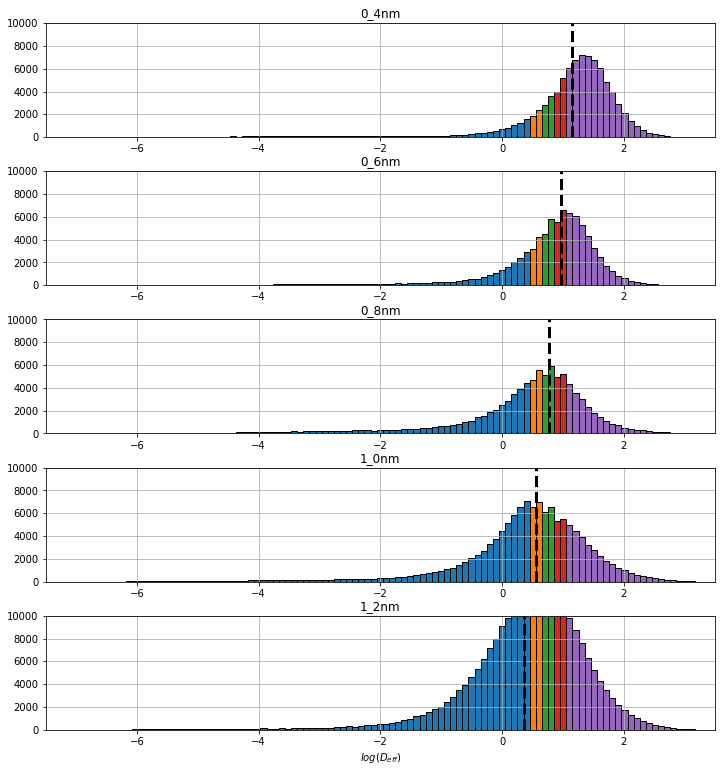

In [152]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.46210, 0.665, 0.865, 1.0576, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=5, figsize=(12, 13))
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Percent Agarose']==gels[counter]]['LogDeff1'].median())
    for i in range(5):
        fstats_tot[(fstats_tot['Percent Agarose']==gels[counter]) & (Dbins[i] < fstats_tot['LogDeff1']) & (fstats_tot['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(means1[counter], color='k', linestyle='dashed', linewidth=3)
    ax.set_title(gels[counter]+ 'nm')
    if counter == 4:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [100]:
pore_model(ngels, 100, 40)

array([ 0.61324916,  0.47723029,  0.38003244,  0.30936016,  0.25680385])

In [29]:
fstats_tot['Percent Agarose Int'] = fstats_tot['Percent Agarose']

In [30]:
fstats_tot['Percent Agarose Int'] = fstats_tot['Percent Agarose Int'].replace('0_4', 0.4)
fstats_tot['Percent Agarose Int'] = fstats_tot['Percent Agarose Int'].replace('0_6', 0.6)
fstats_tot['Percent Agarose Int'] = fstats_tot['Percent Agarose Int'].replace('0_8', 0.8)
fstats_tot['Percent Agarose Int'] = fstats_tot['Percent Agarose Int'].replace('1_0', 1.0)
fstats_tot['Percent Agarose Int'] = fstats_tot['Percent Agarose Int'].replace('1_2', 1.2)

In [52]:
fstats_tot['Percent Agarose Int'].mean()

In [83]:
nmeans = np.exp(np.array(means))/Draw
nmeans

array([ 0.85090712,  0.60651516,  0.44737267,  0.40944922,  0.40598203])

In [80]:
ngels = np.array([0.4, 0.6, 0.8, 1.0, 1.2])
ngels

array([ 0.4,  0.6,  0.8,  1. ,  1.2])

In [106]:
popt, pcov = curve_fit(pore_model, ngels, nmeans, p0=[100, 40])

In [109]:
a = popt[0]
b = popt[1]
gelpred = (((70+b)/np.sqrt(-np.log(Drat)/np.pi)) - 2*b)/a

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
gelpred

0         0.581036
1              NaN
2         3.113519
3         2.198300
4              NaN
5              NaN
6         1.598021
7         0.174053
8         2.369405
9         0.288538
10        1.707748
11        2.175714
12        1.186060
13        1.744725
14        1.963600
15             NaN
16        2.676494
17        3.369062
18        1.197445
19        1.251833
20        0.735909
21             NaN
22             NaN
23        2.000614
24             NaN
25             NaN
26             NaN
27        1.238305
28        0.994417
29             NaN
            ...   
640498         NaN
640499    4.283838
640500    0.285344
640501    0.997654
640502    0.944920
640503    0.713182
640504    0.396697
640505         NaN
640506    4.249961
640507    1.083867
640508         NaN
640509    1.020270
640510    4.554332
640511    0.790887
640512         NaN
640513    1.360977
640514    1.433682
640515    0.855677
640516    0.788797
640517    7.682528
640518    0.979082
640519    0.

In [119]:
y_pred2 = pd.Series(list(pd.cut(gelpred.values, bins=[0, 0.5, 0.7, 0.9, 1.1, 100000], labels=['0_4', '0_6', '0_8', '1_0', '1_2']).astype(str)))

In [121]:
ypred2 = y_pred2.replace('nan', '0_4')

In [127]:
ytrue2 = fstats_play['Percent Agarose']

In [130]:
print(classification_report(ytrue2, ypred2, digits=4))

             precision    recall  f1-score   support

        0_4     0.2553    0.4086    0.3142     90024
        0_6     0.0630    0.0605    0.0617     84767
        0_8     0.1479    0.1643    0.1556     92544
        1_0     0.2316    0.1507    0.1826    128779
        1_2     0.3255    0.3041    0.3144    244218

avg / total     0.2363    0.2355    0.2315    640332



In [55]:
fstats_tot['LogDeff1'] = np.log(fstats_tot.Deff1).replace([np.inf, -np.inf], np.nan)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [24]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

[ 0.52008899  0.56863052  0.76508894  1.08654445]


In [135]:
Drat1 = fstats_play[fstats_play['Percent Agarose'].isin(['0_4', '0_8', '1_2'])].Deff1/Draw

gelpred1 = (((70+b)/np.sqrt(-np.log(Drat1)/np.pi)) - 2*b)/a
y_pred3 = pd.Series(list(pd.cut(gelpred1.values, bins=[0, 0.6, 1.0, 100000], labels=['0_4', '0_8', '1_2']).astype(str)))
ypred3 = y_pred3.replace('nan', '0_4')
ytrue3 = fstats_play[fstats_play['Percent Agarose'].isin(['0_4', '0_8', '1_2'])]['Percent Agarose']

print(classification_report(ytrue3, ypred3, digits=4))

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


             precision    recall  f1-score   support

        0_4     0.3016    0.4201    0.3512     90024
        0_8     0.2266    0.3163    0.2640     92544
        1_2     0.5182    0.3654    0.4286    244218

avg / total     0.4093    0.3663    0.3766    426786



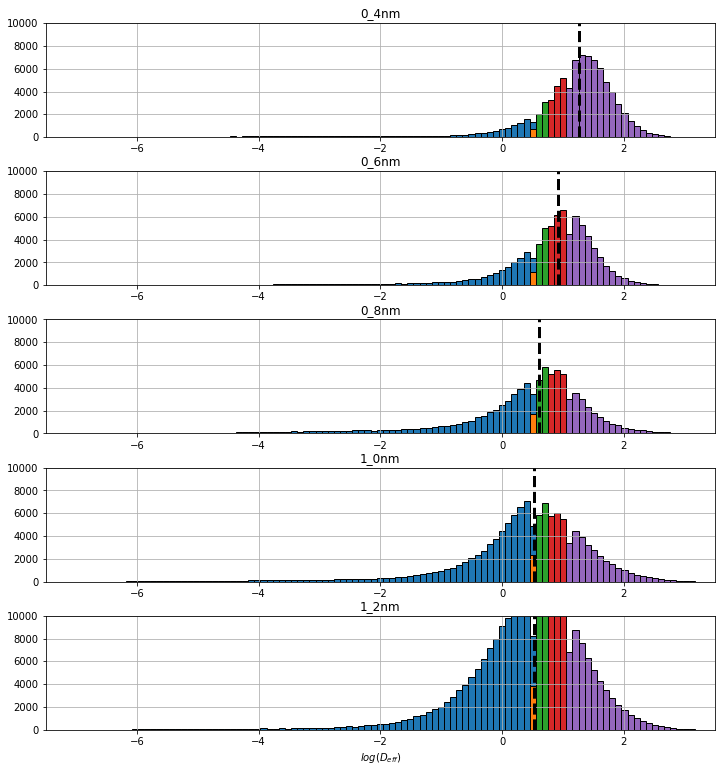

In [136]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.520, 0.5686, 0.7651, 1.0865, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=5, figsize=(12, 13))
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Percent Agarose']==gels[counter]]['LogDeff1'].median())
    for i in range(5):
        fstats_tot[(fstats_tot['Percent Agarose']==gels[counter]) & (Dbins[i] < fstats_tot['LogDeff1']) & (fstats_tot['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(fstats_tot[fstats_tot['Percent Agarose']==gels[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(gels[counter]+ 'nm')
    if counter == 4:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [27]:
y_true2 = fstats_tot['Percent Agarose'].values
y_pred2 = list(pd.cut(fstats_tot['LogDeff1'].values, bins=Dbins, labels=['1_2', '1_0', '0_8', '0_6', '0_4']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        0_4     0.2942    0.6225    0.3996     90033
        0_6     0.1842    0.2352    0.2066     84768
        0_8     0.1750    0.1210    0.1431     92580
        1_0     0.2392    0.0272    0.0488    128847
        1_2     0.4664    0.5021    0.4836    244300
        nan     0.0000    0.0000    0.0000         0

avg / total     0.3170    0.3331    0.2984    640528



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [139]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

[ 0.56437852  0.93437557]


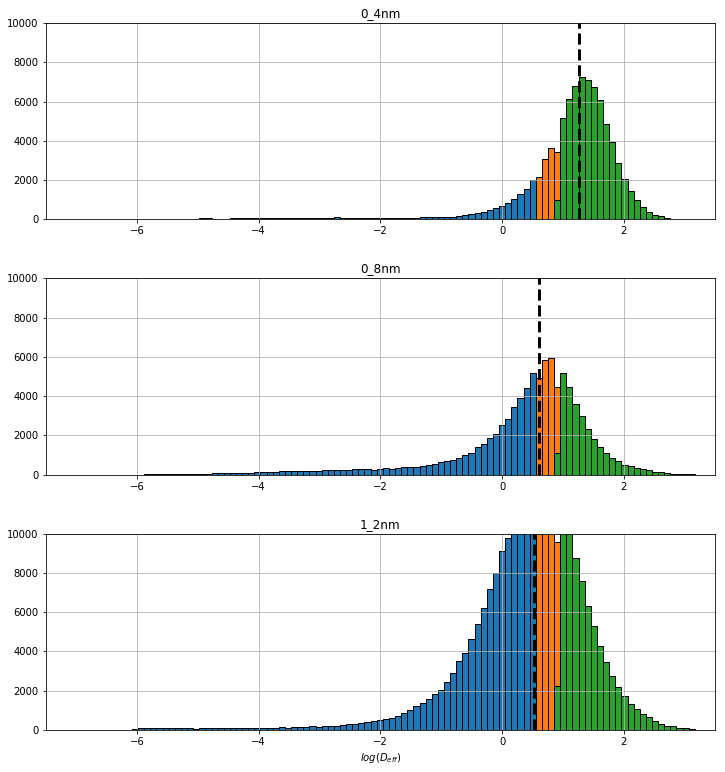

In [140]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.56440, 0.9344, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 13))
gels1 = ['0_4', '0_8', '1_2']
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Percent Agarose']==gels1[counter]]['LogDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Percent Agarose']==gels1[counter]) & (Dbins[i] < fstats_tot['LogDeff1']) & (fstats_tot['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(fstats_tot[fstats_tot['Percent Agarose']==gels1[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(gels1[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [141]:
y_true2 = fstats_tot[fstats_tot['Percent Agarose'].isin(['0_4', '0_8', '1_2'])]['Percent Agarose'].values
y_pred2 = list(pd.cut(fstats_tot[fstats_tot['Percent Agarose'].isin(['0_4', '0_8', '1_2'])]['LogDeff1'].values, bins=Dbins, labels=['1_2', '0_8', '0_4']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        0_4     0.3939    0.7118    0.5072     90033
        0_8     0.2677    0.2283    0.2464     92580
        1_2     0.6909    0.5236    0.5957    244300
        nan     0.0000    0.0000    0.0000         0

avg / total     0.5365    0.4992    0.5013    426913



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
fstats_tot['LogMeanDeff1'] = np.log(fstats_tot['Mean Deff1']).replace([np.inf, -np.inf], np.nan)

In [30]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

[ 0.67481765  0.71518033  0.86904528  1.17249135]


In [33]:
means

[1.3370050350416356,
 1.007977658346461,
 0.7002477497501645,
 0.649387547133049,
 0.7301129035305295]

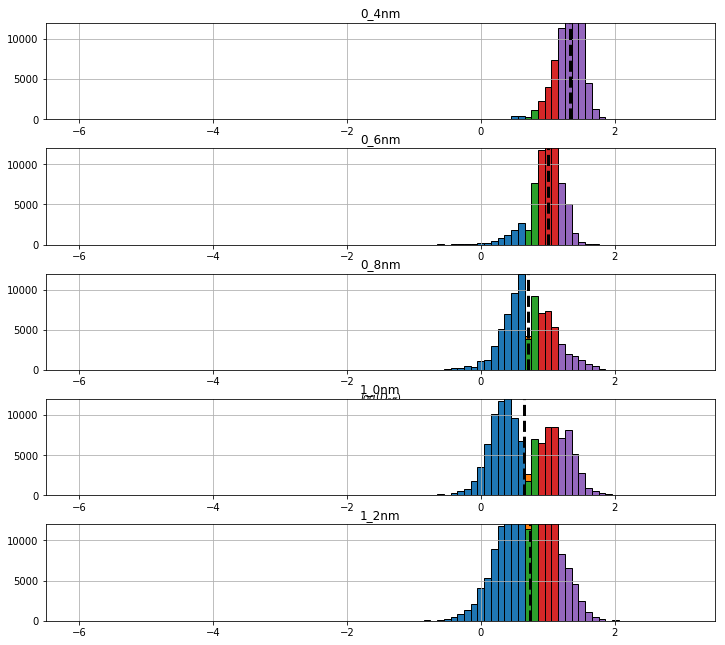

In [31]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.6748, 0.7152, 0.8690, 1.172, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=5, figsize=(12, 11))
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Percent Agarose']==gels[counter]]['LogMeanDeff1'].median())
    for i in range(5):
        fstats_tot[(fstats_tot['Percent Agarose']==gels[counter]) & (Dbins[i] < fstats_tot['LogMeanDeff1']) & (fstats_tot['LogMeanDeff1'] < Dbins[i+1])].hist(column='LogMeanDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-6.5, 3.5])
        ax.set_ylim([0, 12000])
    ax.axvline(fstats_tot[fstats_tot['Percent Agarose']==gels[counter]]['LogMeanDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(gels[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [32]:
y_true2 = fstats_tot['Percent Agarose'].values
y_pred2 = list(pd.cut(fstats_tot['LogMeanDeff1'].values, bins=Dbins, labels=['1_2', '1_0', '0_8', '0_6', '0_4']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        0_4     0.4955    0.8003    0.6120     90033
        0_6     0.2901    0.5699    0.3845     84768
        0_8     0.1802    0.1609    0.1700     92580
        1_0     0.1237    0.0204    0.0351    128847
        1_2     0.4723    0.4344    0.4525    244300
        nan     0.0000    0.0000    0.0000         0

avg / total     0.3391    0.3809    0.3411    640528



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0,0.5,'Validation Scores')

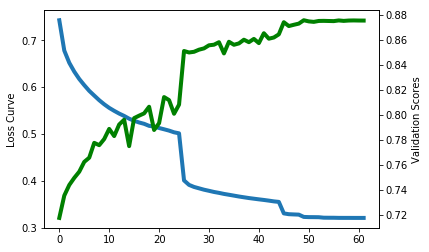

In [28]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.04, 0.18])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.94, 0.99])
ax2.set_ylabel('Validation Scores')

In [ ]:
print('Training Results')
y_true1, y_pred1 = y_train, clf.predict(X_train)
print(classification_report(y_true1, y_pred1, digits=4))

print('Test Results')
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=4))

In [ ]:
classification_report()

In [ ]:
Deff1 = fstats_sub.Deff1.values

In [ ]:
bins = [0, 1.872, 3.858, 10**20]
binned = np.histogram(Deff1, [0, 1.872, 3.858, 10**20])

In [ ]:
binned

In [ ]:
y_pred2 = list(pd.cut(fstats_tot.Deff1.values, bins=[0, 1.872, 3.858, 1000], labels=['500', '200', '100']).astype(str))
y_true2 = fstats_tot['Particle Size'].values

In [ ]:
print(classification_report(y_true2, y_pred2, digits=4))

In [ ]:
kb = 1.381*10**-23
T = 303
nu = 0.000797


size2 = 2*10**9*10**12*kb*T/(fstats_tot.Deff1.values*6*np.pi*nu)

In [ ]:
y_pred2 = list(pd.cut(size2, bins=[-100, 150, 350, 1000000], labels=['100', '200', '500']).astype(str))

In [ ]:
print(classification_report(y_true2, y_pred2, digits=4))

In [ ]:
fstats_tot.hist(column='Deff1', by='Particle Size', sharex=True, bins=np.linspace(0, 10, 100),
                figsize=(9, 7), grid=False, layout=(3,1), sharey=True, )

In [ ]:
fstats_tot['LogDeff1'] = np.log(fstats_tot.Deff1).replace([np.inf, -np.inf], np.nan)

In [ ]:
bins = np.linspace(-10, 10, 200)
axes = fstats_tot.hist(column='LogDeff1', by='Particle Size', layout=(3, 1), bins=bins, sharex=True, sharey=True,
                        figsize=(10, 8), edgecolor='k')

means = []
types2 = ['100', '200', '500']
for ax, typ in zip(axes, types2):
    ax.set_ylim([0,10000])
    #ax.set_xscale("log", nonposx='clip')
    ax.set_xlim([-7.5,3.5])
    means.append(fstats_tot[fstats_tot['Particle Size']==typ]['LogDeff1'].median())
    ax.axvline(fstats_tot[fstats_tot['Particle Size']==typ]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)

In [ ]:
means

In [ ]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

In [ ]:
import matplotlib.pyplot as plt
Dbins = [-10, -0.233, 0.895, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogDeff1']) & (fstats_tot['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [ ]:
y_true2 = fstats_tot['Particle Size'].values
y_pred2 = list(pd.cut(fstats_tot['LogDeff1'].values, bins=Dbins, labels=['500', '200', '100']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

In [ ]:
fstats_tot['LogMeanDeff1'] = np.log(fstats_tot['Mean Deff1']).replace([np.inf, -np.inf], np.nan)

In [ ]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

In [ ]:
Dbins = [-10, -0.0937, 0.9617, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogMeanDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogMeanDeff1']) & (fstats_tot['LogMeanDeff1'] < Dbins[i+1])].hist(column='LogMeanDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogMeanDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [ ]:
y_true2 = fstats_tot['Particle Size'].values
y_pred2 = list(pd.cut(fstats_tot['LogMeanDeff1'].values, bins=Dbins, labels=['500', '200', '100']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

In [ ]:
y_pred2 = list(pd.cut(size2, bins=[-100, 150, 350, 1000000], labels=['100', '200', '500']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

In [ ]:
size3 = np.random.rand(len(size2))
y_pred2 = list(pd.cut(size3, bins=[0, 0.33333333, 0.666666666, 10], labels=['100', '200', '500']).astype(str))

In [ ]:
print(classification_report(y_true2, y_pred2, digits=4))

In [ ]:
size2 = 2*10**9*10**12*kb*T/(fstats_tot['Mean Deff1'].values*6*np.pi*nu)
y_pred2 = list(pd.cut(size2, bins=[-100, 150, 350, 1000000], labels=['100', '200', '500']).astype(str))

In [ ]:
print(classification_report(y_true2, y_pred2, digits=4))

In [ ]:
kb = 1.381*10**-23
T = 303
nu = 0.000797

sizes3 = np.array([150, 350])
Dbins2 = np.log(2*10**9*10**12*kb*T/(sizes3*6*np.pi*nu))
Dbins2.sort()
Dbins2

In [ ]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.4648, 1.3120, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
Ds = np.log(2*10**9*10**12*kb*T/(np.array([100, 200, 500])*6*np.pi*nu))
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogDeff1']) & (fstats_tot['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(Ds[counter], color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [ ]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.4648, 1.3120, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
Ds = np.log(2*10**9*10**12*kb*T/(np.array([100, 200, 500])*6*np.pi*nu))
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogMeanDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogMeanDeff1']) & (fstats_tot['LogMeanDeff1'] < Dbins[i+1])].hist(column='LogMeanDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(Ds[counter], color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1